**Step 1: Setting Up the Environment**

1.1 Install mrjob and PySpark

In [ ]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install PySpark
!pip install pyspark

# Install mrjob
!pip install mrjob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

1.2 Import Libraries and Initialize Spark



In [ ]:
import os
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd

# Set Java environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("CourseAdvisingAnalysis") \
    .getOrCreate()

sc = spark.sparkContext


**Step 2: Loading the Dataset**

In [ ]:
import pandas as pd

# Load the Excel file into a Pandas DataFrame
df_pandas = pd.read_excel('Course_Advising_shuffled_file.xlsx')

# Display the first few rows

df_pandas.head()



,StudentId,CreditsCompleted,takencredit,takennocourse,C1,C2,C3,C4,C5,C6,C7
0,1,29.5,14.5,4,CSE110,ECO101,MAT205,PHY109,NaN,NaN,NaN
1,2,41.0,14.0,4,CSE207,CSE209,MAT205,PHY209,NaN,NaN,NaN
2,3,17.5,17.5,5,CSE110,ENG102,MAT102,MAT104,PHY109,NaN,NaN
3,4,44.5,13.5,4,CSE110,GEN203,MAT101,MAT205,NaN,NaN,NaN
4,5,82.0,4.0,1,CSE303,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(df_pandas)

# Show Spark DataFrame schema
print("\nSchema of Spark DataFrame:")
df_spark.printSchema()


Schema of Spark DataFrame:
root
 |-- StudentId: long (nullable = true)
 |-- CreditsCompleted: double (nullable = true)
 |-- takencredit: double (nullable = true)
 |-- takennocourse: long (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)



**Step 3: Descriptive Analytics**

3.1 Frequency Analysis

In [ ]:
from pyspark.sql import functions as F

# List of course columns
course_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# Extract all courses into a single RDD
courses_rdd = df_spark.select(course_columns).rdd.flatMap(lambda row: row)

# Filter out null/None values explicitly
courses_rdd = courses_rdd.filter(lambda course: course is not None and course != 'NaN')

# Count frequency of each course
course_frequency = courses_rdd.map(lambda course: (course, 1)) \
                             .reduceByKey(lambda a, b: a + b) \
                             .sortBy(lambda x: x[1], ascending=False)

# Collect the results
course_freq_list = course_frequency.collect()

# Print frequencies
print("Frequency of individual courses (excluding null and NaN values):")
for course, freq in course_freq_list:
    print(f"{course}: {freq}")

# Identify the most popular course
most_popular_course = course_freq_list[0]
print(f"\nMost popular course: {most_popular_course[0]} with {most_popular_course[1]} enrollments")

# Identify all least popular courses (courses with the minimum enrollment)
min_enrollment = course_freq_list[-1][1]
least_popular_courses = [course for course, freq in course_freq_list if freq == min_enrollment]

print(f"Least popular courses (with {min_enrollment} enrollment{'s' if min_enrollment > 1 else ''}):")
print(", ".join(least_popular_courses))


Frequency of individual courses (excluding null and NaN values):
CSE106: 913
CSE103: 800
ENG101: 709
CSE110: 538
MAT101: 532
STA102: 436
CHE109: 423
PHY109: 422
CSE209: 422
CSE207: 398
CSE200: 395
MAT104: 373
CSE246: 357
MAT205: 355
PHY209: 352
ECO101: 350
CSE302: 279
MAT102: 274
CSE345: 258
GEN226: 255
CSE325: 254
CSE303: 235
CSE251: 226
CSE400: 212
ENG102: 211
CSE347: 203
CSE360: 199
CSE366: 199
CSE405: 169
CSE487: 149
FIN101: 133
CSE495: 113
CSE407: 104
CSE438: 101
CSE412: 100
CSE479: 99
GEN203: 98
CSE475: 94
GEN214: 77
CSE350: 69
CSE489: 57
GEN210: 52
CSE477: 52
MKT101: 45
CSE430: 43
CSE464: 36
ENG099: 35
CSE420: 35
CSE488: 33
ACT101: 31
BUS231: 20
MGT337: 8
BUS101: 4
CSE453: 3
GEN209: 2
ECO102: 2
CE200-: 1
GEN202: 1
GEN205: 1
MAT110: 1

Most popular course: CSE106 with 913 enrollments
Least popular courses (with 1 enrollment):
CE200-, GEN202, GEN205, MAT110


3.2 Pattern Analysis

In [ ]:
from itertools import combinations
from collections import Counter

# Task 2: Analyze combinations of courses

# Select the columns representing courses
course_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# Extract valid course entries for pattern analysis
# This creates a list of valid courses for each row, dropping null/NaN values
valid_courses = df_spark.select(course_columns).rdd.map(lambda row: [course for course in row if course is not None and course != 'NaN']).collect()

# Count pairwise combinations of courses
pair_combinations = Counter()
for courses in valid_courses:
    pair_combinations.update(combinations(courses, 2))

# Count triplet combinations of courses
triplet_combinations = Counter()
for courses in valid_courses:
    triplet_combinations.update(combinations(courses, 3))

# Calculate the average number of courses taken per student
average_courses_per_student = sum(len(courses) for courses in valid_courses) / len(valid_courses)

# Results: Most common pairs and triplets
most_common_pairs = pair_combinations.most_common(5)
most_common_triplets = triplet_combinations.most_common(5)

# Print results
print("Most common pairs of courses:")
for pair, count in most_common_pairs:
    print(f"{pair}: {count}")

print("\nMost common triplets of courses:")
for triplet, count in most_common_triplets:
    print(f"{triplet}: {count}")

print(f"\nAverage number of courses taken per student: {average_courses_per_student:.2f}")


Most common pairs of courses:
('CSE106', 'ENG101'): 693
('CSE103', 'CSE106'): 666
('CSE103', 'ENG101'): 662
('CSE106', 'MAT101'): 509
('CSE103', 'MAT101'): 486

Most common triplets of courses:
('CSE103', 'CSE106', 'ENG101'): 614
('CSE103', 'CSE106', 'MAT101'): 419
('CSE106', 'ENG101', 'MAT101'): 308
('CSE103', 'ENG101', 'MAT101'): 278
('CHE109', 'CSE103', 'CSE106'): 251

Average number of courses taken per student: 4.17


3.3 Statistical Measures

In [ ]:
from pyspark.sql import functions as F

# Select numerical columns
numerical_cols = ['CreditsCompleted', 'takencredit', 'takennocourse']

# Filter out null/None values explicitly
courses_rdd = courses_rdd.filter(lambda course: course is not None and course != 'NaN')

# Calculate mean
mean_values = df_spark.select([F.mean(c).alias(c) for c in numerical_cols]).collect()[0]
print("\nMean values:")
for col in numerical_cols:
    print(f"{col}: {mean_values[col]:.2f}")

# Calculate median using approxQuantile
median_values = {}
for col in numerical_cols:
    median = df_spark.approxQuantile(col, [0.5], 0.001)[0]
    median_values[col] = median

print("\nMedian values:")
for col, median in median_values.items():
    print(f"{col}: {median}")

# Calculate mode using RDD
for col in numerical_cols:
    mode = df_spark.select(col).rdd.map(lambda row: row[0]) \
                .filter(lambda x: x is not None) \
                .map(lambda x: (x, 1)) \
                .reduceByKey(lambda a, b: a + b) \
                .sortBy(lambda x: x[1], ascending=False) \
                .first()
    print(f"Mode of {col}: {mode[0]} with {mode[1]} occurrences")

# Calculate correlation between CreditsCompleted and takencredit
correlation = df_spark.stat.corr("CreditsCompleted", "takencredit")
print(f"\nCorrelation between CreditsCompleted and takencredit: {correlation:.2f}")



Mean values:
CreditsCompleted: 42.56
takencredit: 14.47
takennocourse: 4.17

Median values:
CreditsCompleted: 33.5
takencredit: 14.5
takennocourse: 4.0
Mode of CreditsCompleted: 0.0 with 736 occurrences
Mode of takencredit: 14.5 with 532 occurrences
Mode of takennocourse: 4 with 1761 occurrences

Correlation between CreditsCompleted and takencredit: 0.01


**Step 4: Visualization Tasks**

4.1 Course Popularity

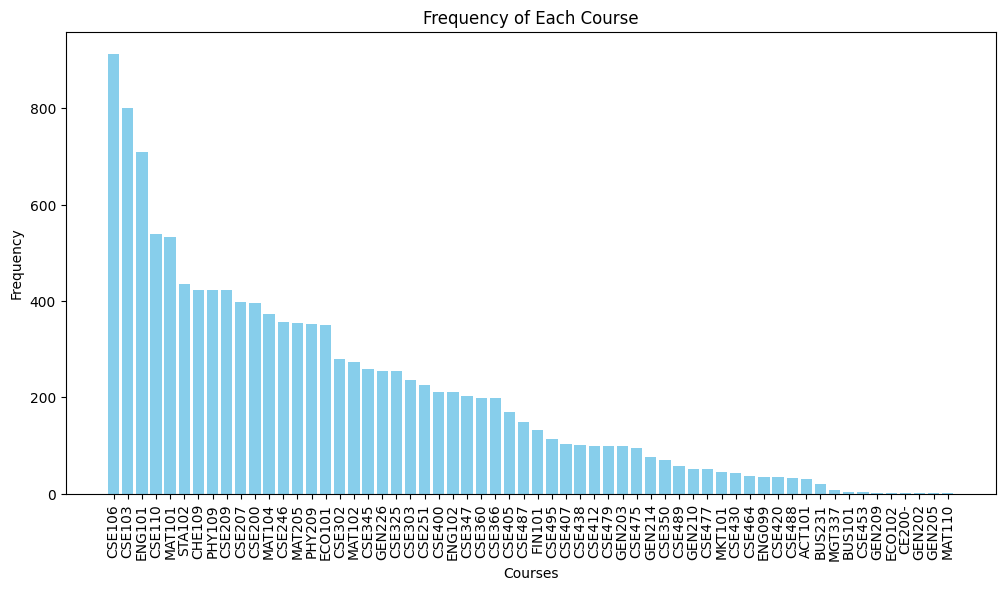

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for easier plotting
course_freq_pd = pd.DataFrame(course_freq_list, columns=['Course', 'Frequency'])

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(course_freq_pd['Course'], course_freq_pd['Frequency'], color='skyblue')
plt.xlabel('Courses')
plt.ylabel('Frequency')
plt.title('Frequency of Each Course')
plt.xticks(rotation=90)
plt.show()


4.2 Combination Patterns

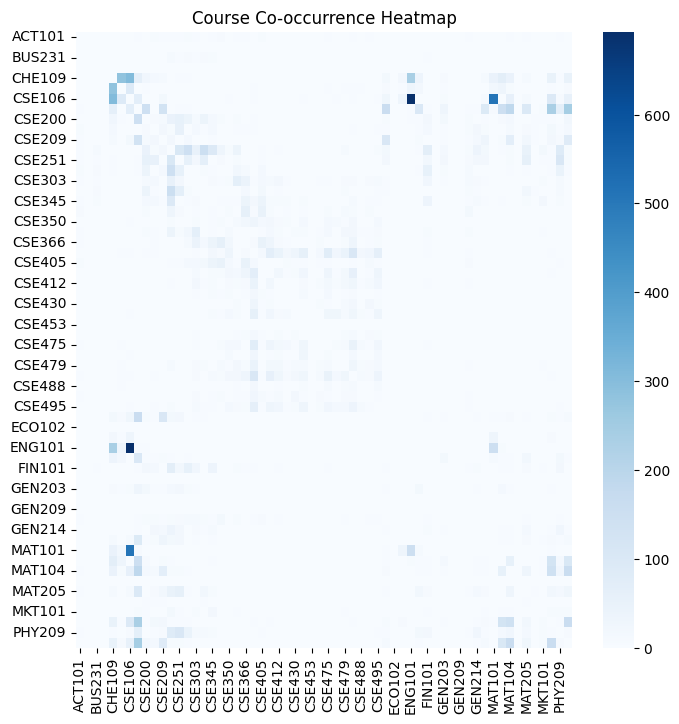

In [ ]:
import seaborn as sns

# Get all pairs with their frequencies
# Use pair_combinations (from Step 3.2) instead of pair_frequency
pair_freq = list(pair_combinations.items())

# Create a dictionary for pair frequencies
pair_dict = {}
for (course1, course2), freq in pair_freq:
    pair_dict.setdefault(course1, {})[course2] = freq
    pair_dict.setdefault(course2, {})[course1] = freq

# Create list of unique courses
courses = sorted(course_freq_pd['Course'].unique())

# Initialize co-occurrence matrix
co_matrix = pd.DataFrame(0, index=courses, columns=courses)

# Fill the matrix
for course1 in courses:
    for course2 in courses:
        if course1 != course2:
            co_matrix.at[course1, course2] = pair_dict.get(course1, {}).get(course2, 0)

# Plot heatmap
plt.figure(figsize=(8,8))
sns.heatmap(co_matrix, annot=False, cmap='Blues')
plt.title('Course Co-occurrence Heatmap')
plt.show()

4.3 Credits Distribution

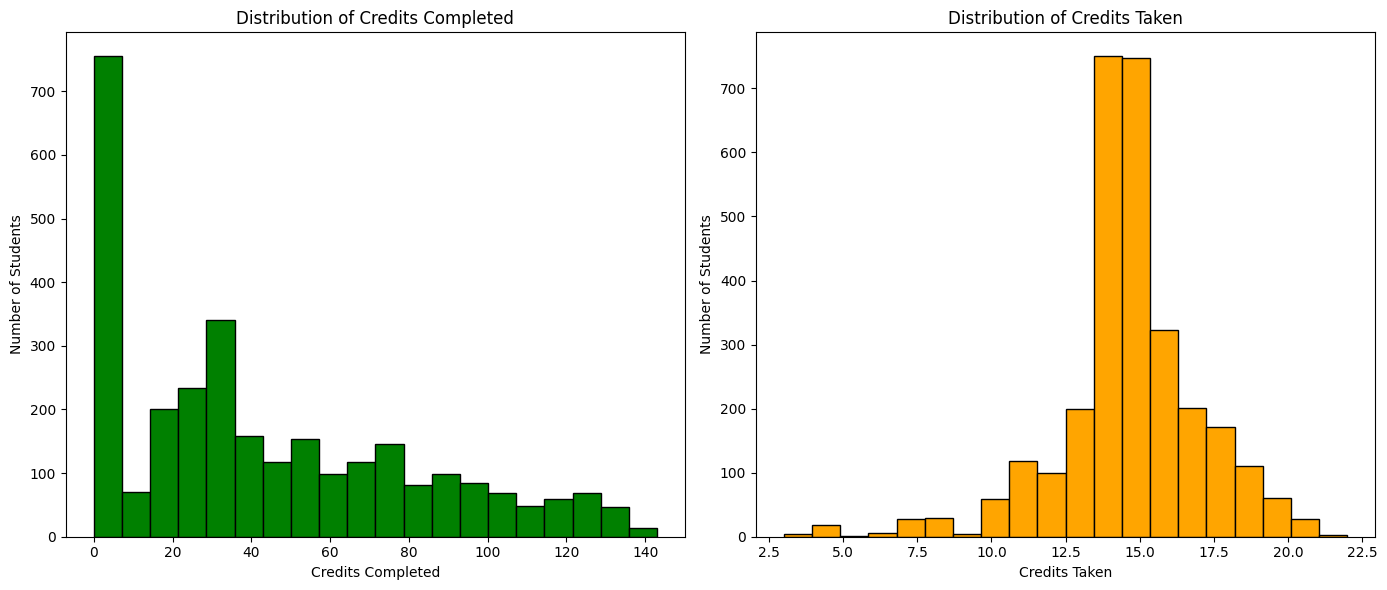

In [ ]:
# Collect data for CreditsCompleted and takencredit
credits_completed = df_spark.select('CreditsCompleted').rdd.map(lambda row: row[0]).collect()
taken_credit = df_spark.select('takencredit').rdd.map(lambda row: row[0]).collect()

# Plot histograms
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.hist(credits_completed, bins=20, color='green', edgecolor='black')
plt.xlabel('Credits Completed')
plt.ylabel('Number of Students')
plt.title('Distribution of Credits Completed')

plt.subplot(1, 2, 2)
plt.hist(taken_credit, bins=20, color='orange', edgecolor='black')
plt.xlabel('Credits Taken')
plt.ylabel('Number of Students')
plt.title('Distribution of Credits Taken')

plt.tight_layout()
plt.show()


4.4 Course Co-occurrence

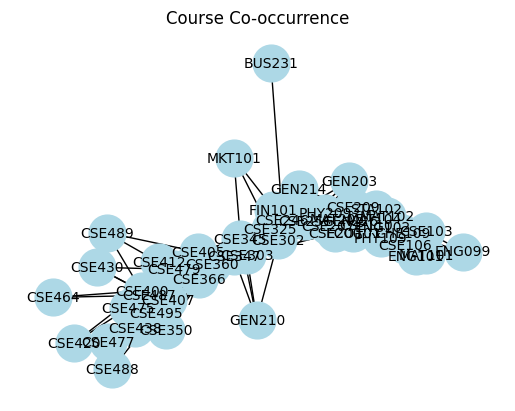

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add edges with weights (frequency)
for (course1, course2), freq in pair_freq:
    if freq > 10:  # Threshold to display significant connections
        G.add_edge(course1, course2, weight=freq)

# Define positions
pos = nx.spring_layout(G, k=0.5)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Course Co-occurrence')
plt.axis('off')
plt.show()


**Step 5: Predictive Analytics**

5.1 Association Rule Mining using Apriori algorithm

In [ ]:
!pip install --upgrade mlxtend

from pyspark.sql.functions import col, explode, array
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F

In [ ]:
# Combine course columns into a single list for each student
df_pandas['Courses'] = df_pandas[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].apply(lambda row: [x for x in row if pd.notna(x)], axis=1)

# Initialize SparkSession
spark = SparkSession.builder.appName("FPGrowth").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df_FPG = spark.createDataFrame(df_pandas[['StudentId', 'Courses']])

# FP-Growth
fp_growth = FPGrowth(itemsCol="Courses", minSupport=0.1, minConfidence=0.2)
model = fp_growth.fit(spark_df_FPG)

# Frequent itemsets
frequent_itemsets = model.freqItemsets
print("Frequent Itemsets:")
frequent_itemsets.show(truncate=False)

print("-------------------------------------------------------------------------------------------------------------------------")

# Association rules
association_rules = model.associationRules
print("Association Rules:")
association_rules.show(truncate=False)

print("-------------------------------------------------------------------------------------------------------------------------")

# Predictions or Recomendation
predictions = model.transform(spark_df_FPG)
print("Predictions:")
predictions.show(truncate=False)


print("==========================================================================================================================")

# Filter for 2-itemsets
frequent_2_itemsets = frequent_itemsets.filter(F.size(F.col("items")) == 2)
print("Frequent 2-Itemsets:")
frequent_2_itemsets.show(truncate=False)


print("Association Rule for  2-Itemsets:")
filtered_rules_2 = association_rules.filter(F.size(F.col("antecedent")) == 2)
filtered_rules_2.show(truncate=False)

print("==========================================================================================================================")

# Filter for 3-itemsets
frequent_3_itemsets = frequent_itemsets.filter(F.size(F.col("items")) == 3)
print("Frequent 3-Itemsets:")
frequent_3_itemsets.show(truncate=False)


print("Association Rule for  3-Itemsets:")
filtered_rules_3 = association_rules.filter(F.size(F.col("antecedent")) == 3)
filtered_rules_3.show(truncate=False)

print("==========================================================================================================================")

print("Recomendation or Prediction Based on the Dataset Pattern")

# Input transactions (multiple rows)
input_items_list = [
    ["CSE103", "ENG101", "MAT101"],
    ["CSE103", "CSE106", "MAT101"],
    ["MAT102", "ENG102", "CSE209"],
    ["CSE110", "MAT102", "CSE200"],
    ["CHE109", "CSE106"]
]

# Initialize an empty DataFrame to store results
final_results = None

# Loop through each row of input transactions
for input_items in input_items_list:
    # Create the filter condition dynamically by iterating over the input items
    filter_condition = None
    for item in input_items:
        if filter_condition is None:
            filter_condition = F.array_contains(F.col("antecedent"), item)
        else:
            filter_condition &= F.array_contains(F.col("antecedent"), item)

    # Filter rules where antecedent is a subset of the input for each row
    relevant_rules = association_rules.filter(filter_condition)

    # If final_results is empty, initialize it with the first batch, otherwise union with existing
    if final_results is None:
        final_results = relevant_rules
    else:
        final_results = final_results.union(relevant_rules)

# Show the combined relevant rules from all input rows
final_results.show(truncate=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:485: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a 

Frequent Itemsets:
+--------------------------------+----+
|items                           |freq|
+--------------------------------+----+
|[PHY109]                        |422 |
|[ENG101]                        |709 |
|[ENG101, CSE103]                |696 |
|[ENG101, CSE103, CSE106]        |691 |
|[ENG101, CSE106]                |693 |
|[PHY209]                        |352 |
|[MAT101]                        |532 |
|[MAT101, ENG101]                |460 |
|[MAT101, ENG101, CSE103]        |459 |
|[MAT101, ENG101, CSE103, CSE106]|457 |
|[MAT101, ENG101, CSE106]        |457 |
|[MAT101, CSE103]                |508 |
|[MAT101, CSE103, CSE106]        |501 |
|[MAT101, CSE106]                |509 |
|[CSE200]                        |395 |
|[CSE246]                        |357 |
|[CHE109]                        |423 |
|[CHE109, CSE106]                |307 |
|[CSE106]                        |913 |
|[MAT104]                        |373 |
+--------------------------------+----+
only showing top 20 r

5.2 Clustering

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


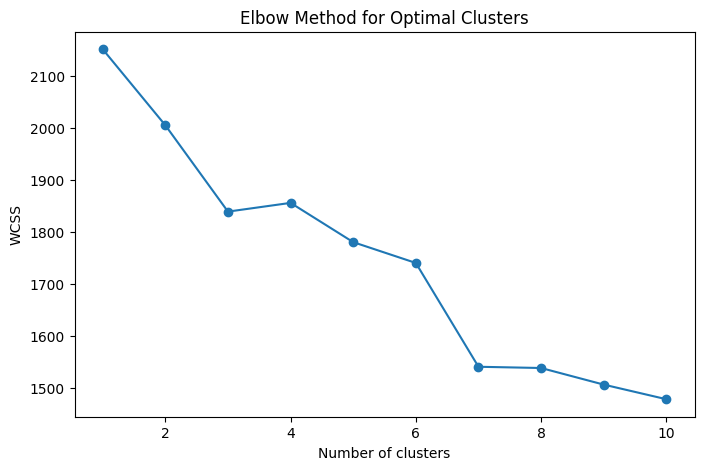


Number of students in each cluster:
Cluster
0    1667
3     609
1     405
2     279
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Determine optimal number of clusters using the elbow method
import matplotlib.pyplot as plt

# Assume df_spark is your original Spark DataFrame
# Convert relevant columns to Pandas DataFrame for clustering
df_encoded = pd.get_dummies(df_spark.toPandas()[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']],
                            prefix=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
                            columns=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']) # One-hot encode categorical features


# For computational efficiency, sample the data if it's large
sampled_data = df_encoded.sample(n=500, random_state=42) if len(df_encoded) > 500 else df_encoded

# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sampled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# From the elbow plot, choose an optimal number of clusters, say k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_encoded)

# Add cluster labels to the DataFrame
df_encoded['Cluster'] = clusters

# Display number of students in each cluster
cluster_counts = df_encoded['Cluster'].value_counts()
print("\nNumber of students in each cluster:")
print(cluster_counts)


**Step 6: Advanced Analytics**

6.1 Recommendation System

In [ ]:
# Simple Recommender: Suggest top courses not yet taken by the student

def recommend_courses(taken_courses, top_n=3):
    # Get a list of all courses from course_freq_pd
    all_courses = course_freq_pd['Course'].unique().tolist()  # Assuming course_freq_pd has all unique courses

    # Courses not yet taken
    not_taken = set(all_courses) - set(taken_courses)

    # Get frequency of not taken courses
    freq_not_taken = course_freq_pd[course_freq_pd['Course'].isin(not_taken)]

    # Recommend top_n courses based on frequency
    recommendations = freq_not_taken.sort_values(by='Frequency', ascending=False).head(top_n)['Course'].tolist()
    return recommendations

# Example: Recommend courses for a student who has taken CS101, CS102, CS103
example_taken_courses = ['CS101', 'CS102', 'CS103']
recommended = recommend_courses(example_taken_courses)
print(f"\nCourses taken: {example_taken_courses}")
print(f"Recommended courses: {recommended}")


Courses taken: ['CS101', 'CS102', 'CS103']
Recommended courses: ['CSE106', 'CSE103', 'ENG101']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6.2 Comparison of Student Behaviors

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


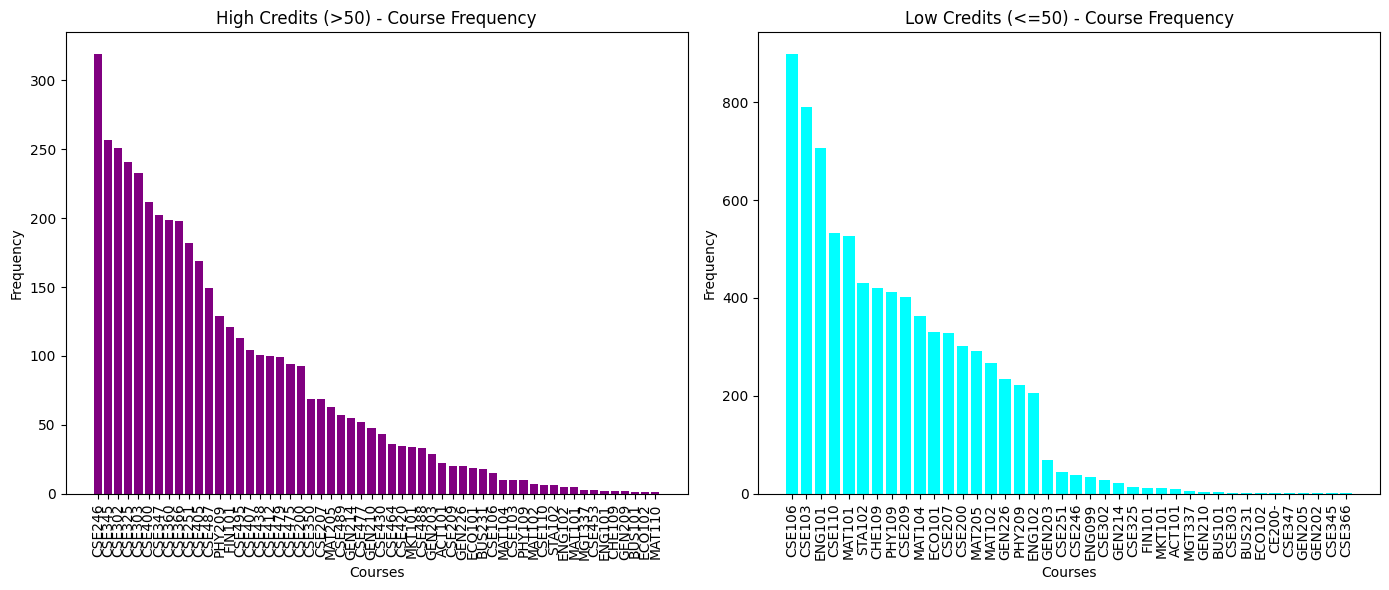


Top 5 courses for High Credits students:
    Course  Frequency
3   CSE246        319
9   CSE345        257
35  CSE302        251
36  CSE325        241
0   CSE303        233

Top 5 courses for Low Credits students:
    Course  Frequency
29  CSE106        898
10  CSE103        790
11  ENG101        707
0   CSE110        532
8   MAT101        527


In [ ]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Split students based on CreditsCompleted > 50
high_credits_df = df_spark.filter(df_spark.CreditsCompleted > 50)
low_credits_df = df_spark.filter(df_spark.CreditsCompleted <= 50)

# Function to get course frequencies while handling NaN
def get_course_freq(df, course_cols):
    """
    This function calculates course frequencies from the given DataFrame while
    explicitly handling NaN values.
    """
    return (
        df.select(course_cols)  # Select course columns
        .rdd.flatMap(lambda row: row)  # Flatten rows into a single RDD
        .filter(lambda x: x is not None and str(x).strip().lower() != "nan")  # Filter out None and 'NaN'
        .map(lambda course: (course, 1))  # Create key-value pairs (course, 1)
        .reduceByKey(lambda a, b: a + b)  # Aggregate frequencies
        .collect()  # Collect as a list
    )

# Get frequencies for High and Low Credits groups
high_freq = get_course_freq(high_credits_df, course_columns)
low_freq = get_course_freq(low_credits_df, course_columns)

# Convert to Pandas DataFrame for visualization
high_freq_pd = pd.DataFrame(high_freq, columns=['Course', 'Frequency']).sort_values(by='Frequency', ascending=False)
low_freq_pd = pd.DataFrame(low_freq, columns=['Course', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot side by side
plt.figure(figsize=(14, 6))

# High Credits group plot
plt.subplot(1, 2, 1)
plt.bar(high_freq_pd['Course'], high_freq_pd['Frequency'], color='purple')
plt.xlabel('Courses')
plt.ylabel('Frequency')
plt.title('High Credits (>50) - Course Frequency')
plt.xticks(rotation=90)

# Low Credits group plot
plt.subplot(1, 2, 2)
plt.bar(low_freq_pd['Course'], low_freq_pd['Frequency'], color='cyan')
plt.xlabel('Courses')
plt.ylabel('Frequency')
plt.title('Low Credits (<=50) - Course Frequency')
plt.xticks(rotation=90)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Analysis
print("\nTop 5 courses for High Credits students:")
print(high_freq_pd.head(5))

print("\nTop 5 courses for Low Credits students:")
print(low_freq_pd.head(5))


**Creative and Open-Ended Projects**

Building an Interactive Dashboard

In [ ]:
# Install Dash
!pip install dash

# Import Dash libraries
import dash
from dash import dcc, html
import plotly.express as px

# Initialize Dash app
app = dash.Dash(__name__)

# Prepare data for visualization
fig_course_popularity = px.bar(course_freq_pd, x='Course', y='Frequency',
                               title='Course Popularity',
                               labels={'Frequency': 'Number of Enrollments'})

# Define layout
app.layout = html.Div(children=[
    html.H1(children='Course Advising Dashboard'),

    html.Div(children='''
        Interactive visualizations of course-taking behaviors.
    '''),

    dcc.Graph(
        id='course-popularity',
        figure=fig_course_popularity
    ),

    # Add more graphs as needed
])

# Run the Dash app
# Note: In Colab, Dash apps require ngrok or other tunneling services to display.
# Alternatively, you can develop the dashboard locally or use other platforms.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
